### Import Modules and Pathways

In [2]:
# Set pathways and initialize model
import os
import re
import time
import torch

import numpy as np
import pandas as pd
import utils.preprocess as pp
import utils.evaluate as evaluate

from collections import defaultdict
from cellpose import models, core, io

# set pathways to test files
# Paths to annotated test data
base_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/images/'
output_root = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train'

# create output directory if it doesn't already exist
if not os.path.exists(output_root):
    os.mkdir(output_root)

# have cellpose log run
io.logger_setup()

# initialize model
use_GPU = core.use_gpu()
model = models.Cellpose(gpu = use_GPU, model_type = 'nuclei')

In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elyse/miniconda3/envs/segment_compare/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

2022-12-12 08:42:02,955 [INFO] WRITING LOG OUTPUT TO /home/elyse/.cellpose/run.log
2022-12-12 08:42:05,808 [INFO] ** TORCH CUDA version installed and working. **
2022-12-12 08:42:05,810 [INFO] ** TORCH CUDA version installed and working. **
2022-12-12 08:42:05,810 [INFO] >>>> using GPU
2022-12-12 08:42:05,812 [INFO] >> nuclei << model set to be used
2022-12-12 08:42:06,015 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


### Import Annotation Data

In [3]:
# Get annotated data and image file paths
blocks = defaultdict(dict)

# loop through base directory and collect all data from "block_#" subfolders
for root, dirs, files in os.walk(base_dir):
    if 'block' in root: 
        for file in files:
            try:
                block_num = re.findall('[0-9]', file)[0]
            except:
                continue
            if 'signal' in file:
                blocks[block_num]['signal'] = os.path.join(root, file)
            elif 'background' in file:
                blocks[block_num]['background'] = os.path.join(root, file)
            elif 'detect' in file:
                blocks[block_num]['detect'] = pp.get_locations(os.path.join(root, file))
            else:
                blocks[block_num]['reject'] = pp.get_locations(os.path.join(root, file))

# print info on blocks        
for key in blocks.keys():
    try:
        rejected = len(blocks[key]['reject'])
    except:
        rejected = 0
    print('Pulled annotation data for block {0}: {1} cells and {2} noncells.'.format(str(key), len(blocks[key]['detect']), rejected))

Pulled annotation data for block 4: 2168 cells and 0 noncells.
Pulled annotation data for block 1: 1751 cells and 2 noncells.
Pulled annotation data for block 3: 410 cells and 5 noncells.
Pulled annotation data for block 2: 1641 cells and 2 noncells.


In [4]:
# There are 3 ways to run 3D Cellpose. The first 2 are exrapolating 2D to 3D
# This is very time consuming if ytou do not GPU access
# The Third way is using new Cellpose3D repo in other script
import skimage.io
import utils.preprocess as pp
from skimage.measure import regionprops

# Set parameters
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# channels = [0,0] # IF YOU HAVE GRAYSCALE
channels = [0,0]
prob_thresh = 1
stitch_thresh = 0.5
diameter = 8 # unit = px
min_size = 25 # roughly a mask with diam = 5
detect_times = defaultdict(int)

# which methods and channels do you want to run for cellpose
methods = ['flow']
chs = ['signal', 'background']

# parameters for preprocessing
bkg_sub = False
estimator = 'MedianBackground'
pad = 50

for method in methods:
    start_detect = time.time()
    for key in blocks.keys():
        for ch in chs:
            
            print('\n\n####### Running block {0} on {1} channel #######\n\n'.format(key, ch))
            
            fname = os.path.basename(blocks[key][ch])[:-4]
            img = skimage.io.imread(blocks[key][ch])
            
            if bkg_sub:
                img = pp.astro_preprocess(img, estimator, pad = pad)
            
            if method == 'flow':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = True, min_size = min_size)
            elif method == 'stitch':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = False, stitch_threshold = stitch_thresh)

            # get centroids from masks. see: https://github.com/MouseLand/cellpose/issues/337
            centroids = []
            mask_num = []
            candidates = regionprops(masks)
            for c in range(len(candidates)):
                location = [int(x) for x in candidates[c]['centroid']]
                centroids.append(location[::-1])
                mask_num.append(candidates[c]['label'])
        
            if ch == 'signal':
                blocks[key]['pred_detect_' + method] = centroids
                blocks[key]['pred_detect_' + method + '_mask'] = mask_num
            else:
                blocks[key]['pred_reject_' + method] = centroids
                blocks[key]['pred_reject_' + method + '_mask'] = mask_num
            
            # save masks and flows
            output_path = os.path.join(output_root, method)

            # create output directory if it doesn't already exist
            if not os.path.exists(output_path):
                os.mkdir(output_path)
            
            # save masks as tif 
            io.save_masks(img, masks, flows, blocks[key][ch], png = False, tif = True, channels = channels, 
                          save_flows = True, save_outlines = True, savedir = output_path)
            
            # save all data for plotting
            io.masks_flows_to_seg(img, masks, flows, diams, os.path.join(output_path, fname), channels=None)

    detect_times[method] = time.time() - start_detect



####### Running block 4 on signal channel #######


2022-12-12 08:42:07,232 [INFO] ~~~ FINDING MASKS ~~~
2022-12-12 08:42:07,302 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-12-12 08:42:08,926 [INFO] running YX: 150 planes of size (350, 350)
2022-12-12 08:42:24,954 [INFO] 68%|######8   | 51/75 [00:15<00:07,  3.24it/s]


KeyboardInterrupt: 

### Cellpose Outputs and Profile

In [ ]:
# get time to run each method
for method in ['flow']:
    print('Using ' + method + ' method for 2D to 3D')
    for key in blocks.keys():
        print('Classified {0} cells and {1} noncells for annocation block {2}.'.format(len(blocks[key]['pred_detect_' + method]), 
                                                                                       len(blocks[key]['pred_reject_' + method]), 
                                                                                       str(key)))

    print('Detection and Classification via ' + method + ' took {0} seconds.\n'.format(detect_times[method]))

### Plot Performance

In [ ]:
# get metrics on model performance and plot results
import matplotlib.pyplot as plt
%matplotlib inline

methods = ['flow']
max_dist = 10
trained = False
get_keys = []

performance = evaluate.get_performance(blocks, methods, max_dist, trained, get_keys)
evaluate.plot_performance(performance, methods)

### Save Untrained Data

In [ ]:
import pickle

with open('/home/elyse/Documents/cellpose_trained_blocks.pickle', 'wb') as handle:
    pickle.dump(blocks, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Import Data

In [2]:
import pickle

with open('/home/elyse/Documents/cellpose_trained_blocks.pickle', 'rb') as handle:
    blocks = pickle.load(handle)

### Train Model

In [3]:
import random
import pickle
import skimage.io
import utils.preprocess as pp
#Train model using only cells with centroids within N number of px away from annotation
dist = 1
pre_trained = False
load_pkl = True

# parameters for preprocessing
bkg_sub = True
estimator = 'SExtractorBackground'
pad = 50

# directories for model and necessary data
mask_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train/flow'
model_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train/model'
model_name = 'blocks_all_1px_dims_stacked_model'

if load_pkl:
    with open('/home/elyse/Documents/cellpose_base_blocks.pickle', 'rb') as handle:
        blocks = pickle.load(handle)


if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    fname = os.path.join(model_dir, model_name)

if pre_trained:
    model = models.CellposeModel(gpu = use_GPU, pre_trained = fname)
else:
    model = models.CellposeModel(gpu = use_GPU, model_type = 'nuclei')
    

for key in blocks.keys():
    
    if key != '4':
        continue
    
    seg_name = os.path.join(mask_dir, 'block_' + str(key) + '_signal_seg.npy')

    df = evaluate.annot_pred_overlap(blocks, dist, 'flow', False, [key])
    train_ids = df.loc[(df['annotated'] == 1.0) & (df['predicted'] == 1), ['mask_id']].values
    train_ids = np.unique(train_ids)
    
    # keep only masks that are withing the alotted threshold for training
    seg_file = np.load(seg_name, allow_pickle = True).item()
    mask_array = seg_file['masks']
    mask_array = np.where(np.isin(mask_array, train_ids), mask_array, 0)
    img_array = skimage.io.imread(blocks[key]['signal'])
    
    #verify that the number of identified masks is the same as in the masked array
    print('\n\nRunning annotation block {0}.'.format(key))
    print('{0} cells identified within {1} px of annotated cells. Mask array contains {2} unique masks.\n\n'.format(len(train_ids), 
                                                                                                                        dist, 
                                                                                                                        len(np.unique(mask_array)) - 1))
    # increase training data by stacking each dimension
    train_array, mask_array = pp.build_training_stack(img_array, mask_array)
    
    # split masks into train and test arrays (using 80:20 split)
    masks = list(np.unique(mask_array))
    
    train_idx = random.sample(masks, int(len(masks) * 0.8))
    train_masks = np.where(np.isin(mask_array, train_idx), mask_array, 0)
    test_masks = np.where(~np.isin(mask_array, train_idx), mask_array, 0)


    # if you want to train the model with preprocessed data
    if bkg_sub:
        train_array = pp.astro_preprocess(train_array, estimator, pad = pad)

    # format needs to be list of arrays with shape (nchan x Ly x Lx)
    frames = train_array.shape[0]

    img_list = [np.expand_dims(train_array[z, :, :], axis = 0) for z in range(frames)]
    train_list = [np.expand_dims(train_masks[z, :, :], axis = 0) for z in range(frames)]
    test_list = [np.expand_dims(test_masks[z, :, :], axis = 0) for z in range(frames)]
    
    # remove frames without masks
    #img_list, train_list, test_list = [], [], []
    #for z in range(frames):
    #    vals = np.unique(mask_array[z, :, :])
    #    if len(vals) > 1:
    #        img_list.append(np.expand_dims(train_array[z, :, :], axis = 0))
    #        train_list.append(np.expand_dims(train_masks[z, :, :], axis = 0))
    #        test_list.append(np.expand_dims(test_masks[z, :, :], axis = 0))
    
    # initialize new model
    logger = io.logger_setup()
       
    model.train(train_data = img_list, train_labels = train_list,
                test_data = img_list, test_labels = test_list,
                channels = [0, 0], save_path = model_dir, model_name = model_name)

2022-12-07 13:44:20,180 [INFO] >> nuclei << model set to be used
2022-12-07 13:44:20,197 [INFO] ** TORCH CUDA version installed and working. **
2022-12-07 13:44:20,198 [INFO] >>>> using GPU
2022-12-07 13:44:20,374 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


Running annotation block 4.
361 cells identified within 1 px of annotated cells. Mask array contains 361 unique masks.


2022-12-07 13:44:55,618 [INFO] WRITING LOG OUTPUT TO /home/elyse/.cellpose/run.log
2022-12-07 13:45:00,446 [INFO] computing flows for labels


  0%|                                                   | 0/350 [00:00<?, ?it/s]

2022-12-07 13:45:00,576 [WARNING] empty masks!
2022-12-07 13:45:00,577 [WARNING] empty masks!
2022-12-07 13:45:00,578 [WARNING] empty masks!
2022-12-07 13:45:00,579 [WARNING] empty masks!
2022-12-07 13:45:00,579 [WARNING] empty masks!
2022-12-07 13:45:00,580 [WARNING] empty masks!
2022-12-07 13:45:00,581 [WARNING] empty masks!
2022-12-07 13:45:00,581 [WARNING] empty masks!
2022-12-07 13:45:00,582 [WARNING] empty masks!
2022-12-07 13:45:00,583 [WARNING] empty masks!
2022-12-07 13:45:00,584 [WARNING] empty masks!
2022-12-07 13:45:00,584 [WARNING] empty masks!
2022-12-07 13:45:00,585 [WARNING] empty masks!
2022-12-07 13:45:00,586 [WARNING] empty masks!
2022-12-07 13:45:00,586 [WARNING] empty masks!
2022-12-07 13:45:00,587 [WARNING] empty masks!
2022-12-07 13:45:00,588 [WARNING] empty masks!
2022-12-07 13:45:00,588 [WARNING] empty masks!
2022-12-07 13:45:00,589 [WARNING] empty masks!
2022-12-07 13:45:00,590 [WARNING] empty masks!
2022-12-07 13:45:00,591 [WARNING] empty masks!
2022-12-07 13

 35%|█████████████▍                         | 121/350 [00:00<00:00, 1203.75it/s]

2022-12-07 13:45:00,677 [WARNING] empty masks!
2022-12-07 13:45:00,678 [WARNING] empty masks!
2022-12-07 13:45:00,679 [WARNING] empty masks!
2022-12-07 13:45:00,680 [WARNING] empty masks!
2022-12-07 13:45:00,680 [WARNING] empty masks!
2022-12-07 13:45:00,681 [WARNING] empty masks!
2022-12-07 13:45:00,682 [WARNING] empty masks!
2022-12-07 13:45:00,683 [WARNING] empty masks!
2022-12-07 13:45:00,683 [WARNING] empty masks!
2022-12-07 13:45:00,684 [WARNING] empty masks!
2022-12-07 13:45:00,685 [WARNING] empty masks!
2022-12-07 13:45:00,685 [WARNING] empty masks!
2022-12-07 13:45:00,686 [WARNING] empty masks!
2022-12-07 13:45:00,687 [WARNING] empty masks!
2022-12-07 13:45:00,687 [WARNING] empty masks!
2022-12-07 13:45:00,688 [WARNING] empty masks!
2022-12-07 13:45:00,689 [WARNING] empty masks!
2022-12-07 13:45:00,690 [WARNING] empty masks!
2022-12-07 13:45:00,690 [WARNING] empty masks!
2022-12-07 13:45:00,691 [WARNING] empty masks!
2022-12-07 13:45:00,692 [WARNING] empty masks!
2022-12-07 13

 69%|███████████████████████████▋            | 242/350 [00:00<00:00, 254.03it/s]

2022-12-07 13:45:01,417 [WARNING] empty masks!
2022-12-07 13:45:01,418 [WARNING] empty masks!
2022-12-07 13:45:01,418 [WARNING] empty masks!
2022-12-07 13:45:01,419 [WARNING] empty masks!
2022-12-07 13:45:01,420 [WARNING] empty masks!
2022-12-07 13:45:01,421 [WARNING] empty masks!
2022-12-07 13:45:01,421 [WARNING] empty masks!
2022-12-07 13:45:01,422 [WARNING] empty masks!
2022-12-07 13:45:01,423 [WARNING] empty masks!
2022-12-07 13:45:01,424 [WARNING] empty masks!
2022-12-07 13:45:01,427 [WARNING] empty masks!
2022-12-07 13:45:01,428 [WARNING] empty masks!
2022-12-07 13:45:01,429 [WARNING] empty masks!
2022-12-07 13:45:01,429 [WARNING] empty masks!
2022-12-07 13:45:01,430 [WARNING] empty masks!
2022-12-07 13:45:01,431 [WARNING] empty masks!
2022-12-07 13:45:01,432 [WARNING] empty masks!
2022-12-07 13:45:01,432 [WARNING] empty masks!
2022-12-07 13:45:01,433 [WARNING] empty masks!
2022-12-07 13:45:01,434 [WARNING] empty masks!
2022-12-07 13:45:01,434 [WARNING] empty masks!
2022-12-07 13

100%|████████████████████████████████████████| 350/350 [00:00<00:00, 376.99it/s]


2022-12-07 13:45:02,041 [INFO] computing flows for labels


  0%|                                                   | 0/350 [00:00<?, ?it/s]

2022-12-07 13:45:02,153 [WARNING] empty masks!
2022-12-07 13:45:02,154 [WARNING] empty masks!
2022-12-07 13:45:02,155 [WARNING] empty masks!
2022-12-07 13:45:02,156 [WARNING] empty masks!
2022-12-07 13:45:02,158 [WARNING] empty masks!
2022-12-07 13:45:02,159 [WARNING] empty masks!
2022-12-07 13:45:02,160 [WARNING] empty masks!
2022-12-07 13:45:02,162 [WARNING] empty masks!
2022-12-07 13:45:02,163 [WARNING] empty masks!
2022-12-07 13:45:02,165 [WARNING] empty masks!
2022-12-07 13:45:02,166 [WARNING] empty masks!
2022-12-07 13:45:02,168 [WARNING] empty masks!
2022-12-07 13:45:02,169 [WARNING] empty masks!
2022-12-07 13:45:02,171 [WARNING] empty masks!
2022-12-07 13:45:02,172 [WARNING] empty masks!
2022-12-07 13:45:02,174 [WARNING] empty masks!
2022-12-07 13:45:02,175 [WARNING] empty masks!
2022-12-07 13:45:02,177 [WARNING] empty masks!
2022-12-07 13:45:02,178 [WARNING] empty masks!
2022-12-07 13:45:02,179 [WARNING] empty masks!
2022-12-07 13:45:02,181 [WARNING] empty masks!
2022-12-07 13

 21%|████████▌                                | 73/350 [00:00<00:00, 723.03it/s]

2022-12-07 13:45:02,255 [WARNING] empty masks!
2022-12-07 13:45:02,256 [WARNING] empty masks!
2022-12-07 13:45:02,258 [WARNING] empty masks!
2022-12-07 13:45:02,259 [WARNING] empty masks!
2022-12-07 13:45:02,260 [WARNING] empty masks!
2022-12-07 13:45:02,262 [WARNING] empty masks!
2022-12-07 13:45:02,263 [WARNING] empty masks!
2022-12-07 13:45:02,264 [WARNING] empty masks!
2022-12-07 13:45:02,265 [WARNING] empty masks!
2022-12-07 13:45:02,266 [WARNING] empty masks!
2022-12-07 13:45:02,267 [WARNING] empty masks!
2022-12-07 13:45:02,269 [WARNING] empty masks!
2022-12-07 13:45:02,270 [WARNING] empty masks!
2022-12-07 13:45:02,271 [WARNING] empty masks!
2022-12-07 13:45:02,272 [WARNING] empty masks!
2022-12-07 13:45:02,273 [WARNING] empty masks!
2022-12-07 13:45:02,274 [WARNING] empty masks!
2022-12-07 13:45:02,275 [WARNING] empty masks!
2022-12-07 13:45:02,277 [WARNING] empty masks!
2022-12-07 13:45:02,278 [WARNING] empty masks!
2022-12-07 13:45:02,279 [WARNING] empty masks!
2022-12-07 13

 43%|█████████████████▎                      | 151/350 [00:00<00:00, 736.01it/s]

2022-12-07 13:45:02,777 [WARNING] empty masks!
2022-12-07 13:45:02,778 [WARNING] empty masks!
2022-12-07 13:45:02,779 [WARNING] empty masks!
2022-12-07 13:45:02,780 [WARNING] empty masks!
2022-12-07 13:45:02,780 [WARNING] empty masks!
2022-12-07 13:45:02,781 [WARNING] empty masks!
2022-12-07 13:45:02,782 [WARNING] empty masks!
2022-12-07 13:45:02,783 [WARNING] empty masks!
2022-12-07 13:45:02,783 [WARNING] empty masks!
2022-12-07 13:45:02,784 [WARNING] empty masks!
2022-12-07 13:45:02,785 [WARNING] empty masks!
2022-12-07 13:45:02,786 [WARNING] empty masks!
2022-12-07 13:45:02,787 [WARNING] empty masks!
2022-12-07 13:45:02,788 [WARNING] empty masks!
2022-12-07 13:45:02,789 [WARNING] empty masks!
2022-12-07 13:45:02,790 [WARNING] empty masks!
2022-12-07 13:45:02,792 [WARNING] empty masks!
2022-12-07 13:45:02,793 [WARNING] empty masks!
2022-12-07 13:45:02,794 [WARNING] empty masks!
2022-12-07 13:45:02,795 [WARNING] empty masks!
2022-12-07 13:45:02,796 [WARNING] empty masks!
2022-12-07 13

 64%|█████████████████████████▋              | 225/350 [00:00<00:00, 288.70it/s]

2022-12-07 13:45:02,806 [WARNING] empty masks!
2022-12-07 13:45:02,807 [WARNING] empty masks!
2022-12-07 13:45:02,808 [WARNING] empty masks!
2022-12-07 13:45:02,809 [WARNING] empty masks!
2022-12-07 13:45:02,810 [WARNING] empty masks!
2022-12-07 13:45:02,812 [WARNING] empty masks!
2022-12-07 13:45:02,813 [WARNING] empty masks!
2022-12-07 13:45:02,814 [WARNING] empty masks!
2022-12-07 13:45:02,815 [WARNING] empty masks!
2022-12-07 13:45:02,816 [WARNING] empty masks!
2022-12-07 13:45:02,817 [WARNING] empty masks!
2022-12-07 13:45:02,818 [WARNING] empty masks!
2022-12-07 13:45:02,819 [WARNING] empty masks!
2022-12-07 13:45:02,821 [WARNING] empty masks!
2022-12-07 13:45:02,822 [WARNING] empty masks!
2022-12-07 13:45:02,826 [WARNING] empty masks!
2022-12-07 13:45:02,827 [WARNING] empty masks!
2022-12-07 13:45:02,828 [WARNING] empty masks!
2022-12-07 13:45:02,829 [WARNING] empty masks!
2022-12-07 13:45:02,830 [WARNING] empty masks!
2022-12-07 13:45:02,832 [WARNING] empty masks!
2022-12-07 13

 88%|███████████████████████████████████     | 307/350 [00:00<00:00, 394.60it/s]

2022-12-07 13:45:02,907 [WARNING] empty masks!
2022-12-07 13:45:02,908 [WARNING] empty masks!
2022-12-07 13:45:02,910 [WARNING] empty masks!
2022-12-07 13:45:02,911 [WARNING] empty masks!
2022-12-07 13:45:02,913 [WARNING] empty masks!
2022-12-07 13:45:02,914 [WARNING] empty masks!
2022-12-07 13:45:02,915 [WARNING] empty masks!
2022-12-07 13:45:02,916 [WARNING] empty masks!
2022-12-07 13:45:02,917 [WARNING] empty masks!
2022-12-07 13:45:02,918 [WARNING] empty masks!
2022-12-07 13:45:02,919 [WARNING] empty masks!
2022-12-07 13:45:02,920 [WARNING] empty masks!
2022-12-07 13:45:02,921 [WARNING] empty masks!
2022-12-07 13:45:02,922 [WARNING] empty masks!
2022-12-07 13:45:02,924 [WARNING] empty masks!
2022-12-07 13:45:02,925 [WARNING] empty masks!
2022-12-07 13:45:02,926 [WARNING] empty masks!
2022-12-07 13:45:02,927 [WARNING] empty masks!
2022-12-07 13:45:02,928 [WARNING] empty masks!
2022-12-07 13:45:02,929 [WARNING] empty masks!
2022-12-07 13:45:02,930 [WARNING] empty masks!
2022-12-07 13

100%|████████████████████████████████████████| 350/350 [00:00<00:00, 436.04it/s]


2022-12-07 13:45:03,436 [WARNING] 300 train images with number of masks less than min_train_masks (5), removing from train set
2022-12-07 13:45:03,781 [INFO] >>>> median diameter set to = 17
2022-12-07 13:45:03,781 [INFO] >>>> mean of training label mask diameters (saved to model) 5.301
2022-12-07 13:45:03,782 [INFO] >>>> training network with 2 channel input <<<<
2022-12-07 13:45:03,783 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2022-12-07 13:45:03,784 [INFO] >>>> ntrain = 50, ntest = 350
2022-12-07 13:45:03,785 [INFO] >>>> nimg_per_epoch = 50
2022-12-07 13:45:09,116 [INFO] Epoch 0, Time  5.3s, Loss 0.5148, Loss Test 0.0800, LR 0.0000
2022-12-07 13:45:10,099 [INFO] saving network parameters to /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train/model/models/blocks_all_1px_dims_stacked_model
2022-12-07 13:45:16,935 [INFO] Epoch 5, Time 13.2s, Loss 0.1146, Loss Test 0.0052, LR 0.1111
2022-12-07 13:45:24,565 [INFO] Epoch 10, Time 20.8s, Loss 0.0862

### Run Trained Cellpose Model

In [4]:
import skimage.io
import utils.preprocess as pp
from skimage.measure import regionprops

# Rerun with Trained Model:
model_path = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train/models/blocks_all_1px_dims_stacked_model'
model_trained = models.CellposeModel(gpu = use_GPU, pretrained_model = model_path)

# cellpose parameters
channels = [0,0]
prob_thresh = 0.0
diameter = 8 # unit = px (8px is roughly what cellpose calculates in gui calibration)
min_size = 25
detect_times = defaultdict(int)
method = 'flow'
key_root = ['train_detect_', 'train_reject_'] 

# parameters for preprocessing
bkg_sub = False
estimator = 'MedianBackground'
pad = 50

for key in blocks.keys():
    for kr, ch in enumerate(['signal', 'background']):
        
        print('\n\n####### Running block {0} on {1} channel #######\n\n'.format(key, ch))
        
        
        fname = os.path.basename(blocks[key][ch])[:-4] + '_trained'
        img = skimage.io.imread(blocks[key][ch])
    
        if bkg_sub:
            img = pp.astro_preprocess(img, estimator, pad = pad)
    
        masks, flows, styles = model_trained.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                  do_3D = True, min_size = min_size)
    
        # get centroids from masks. see: https://github.com/MouseLand/cellpose/issues/337
        centroids = []
        mask_num = []
        candidates = regionprops(masks)
        for c in range(len(candidates)):
            location = [int(x) for x in candidates[c]['centroid']]
            centroids.append(location[::-1])
            mask_num.append(candidates[c]['label'])
        
        blocks[key][key_root[kr] + method] = centroids
        blocks[key][key_root[kr] + method + '_mask'] = mask_num
            
        # save masks and flows
        output_path = os.path.join(output_root, method)

        # create output directory if it doesn't already exist
        if not os.path.exists(output_path):
            os.mkdir(output_path)
            
        # save masks as tif 
        io.save_masks(img, masks, flows, blocks[key][ch], png = False, tif = True, channels = channels, 
                      save_flows = True, save_outlines = True, savedir = output_path)


2022-12-07 14:14:16,174 [WARNING] pretrained model has incorrect path
2022-12-07 14:14:16,175 [INFO] >> cyto << model set to be used
2022-12-07 14:14:16,192 [INFO] ** TORCH CUDA version installed and working. **
2022-12-07 14:14:16,193 [INFO] >>>> using GPU
2022-12-07 14:14:16,361 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


####### Running block 4 on signal channel #######


2022-12-07 14:14:16,445 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-12-07 14:14:18,644 [INFO] running YX: 150 planes of size (350, 350)
2022-12-07 14:15:16,731 [INFO] 100%|##########| 150/150 [00:57<00:00,  2.62it/s]
2022-12-07 14:15:20,917 [INFO] running ZY: 350 planes of size (150, 350)
2022-12-07 14:16:19,098 [INFO] 100%|##########| 175/175 [00:57<00:00,  3.05it/s]
2022-12-07 14:16:24,118 [INFO] running ZX: 350 planes of size (150, 350)
2022-12-07 14:17:22,435 [INFO] 100%|##########| 175/175 [00:57<00:00,  3.04it/s]
2022-12-07 14:17:25,823 [INFO] 

### Trained Model Outputs and Profile

In [5]:
# get time to run each method
for method in ['flow']:
    print('Using ' + method + ' method for 2D to 3D')
    for key in blocks.keys():
        print('Classified {0} cells and {1} noncells for annotation block {2}.'.format(len(blocks[key]['train_detect_' + method]), 
                                                                                       len(blocks[key]['train_reject_' + method]), 
                                                                                       str(key)))

    print('Detection and Classification via ' + method + ' took {0} seconds.\n'.format(detect_times[method]))

Using flow method for 2D to 3D
Classified 2095 cells and 4 noncells for annotation block 4.
Classified 1740 cells and 3 noncells for annotation block 1.
Classified 385 cells and 13 noncells for annotation block 3.
Classified 1608 cells and 0 noncells for annotation block 2.
Detection and Classification via flow took 0 seconds.



### Save Trained Data

In [1]:
import pickle

with open('/home/elyse/Documents/cellpose_trained_blocks.pickle', 'wb') as handle:
    pickle.dump(blocks, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'blocks' is not defined

### Plot Trained Performance

Top F1 Scores for flow detection: 0.9298186133242923


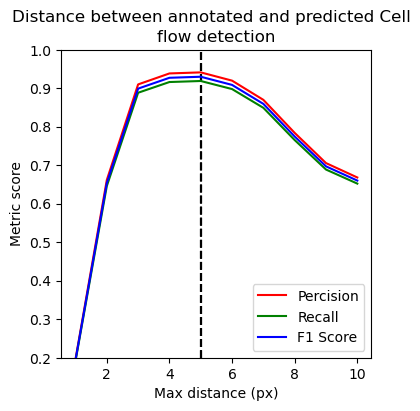

In [6]:
# get metrics on model performance and plot results
method = ['flow']
trained = True
get_keys = []
dist_range = 10

performance = evaluate.get_performance(blocks, method, dist_range, trained, get_keys)
evaluate.plot_performance(performance, method)

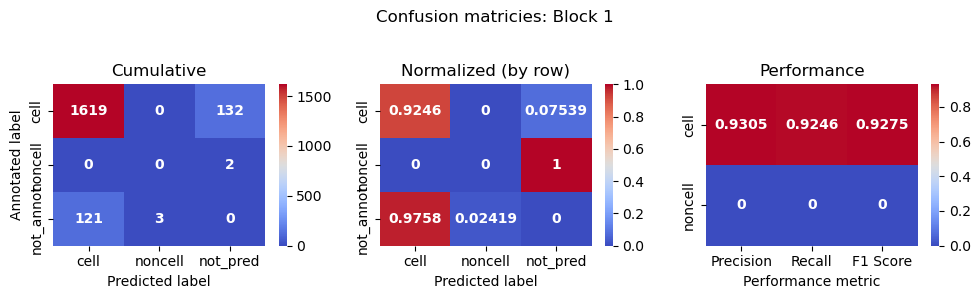

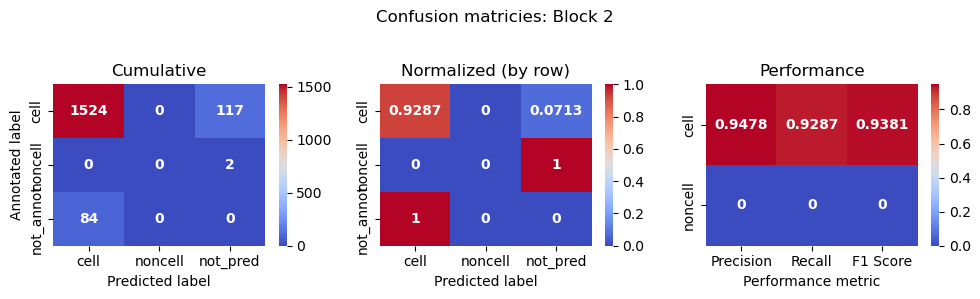

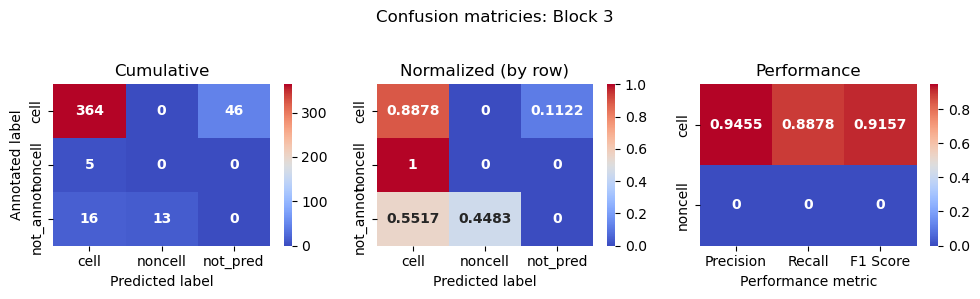

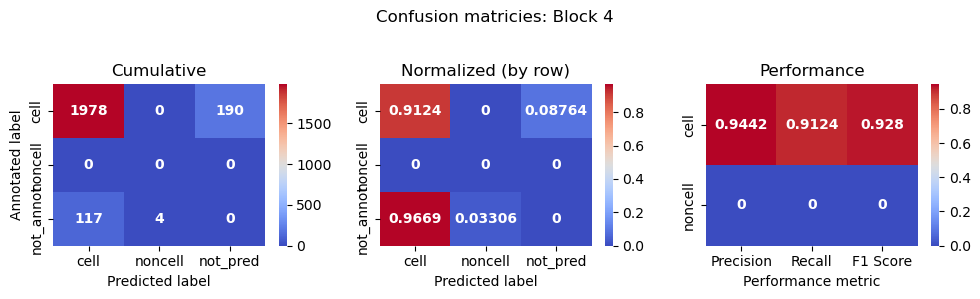

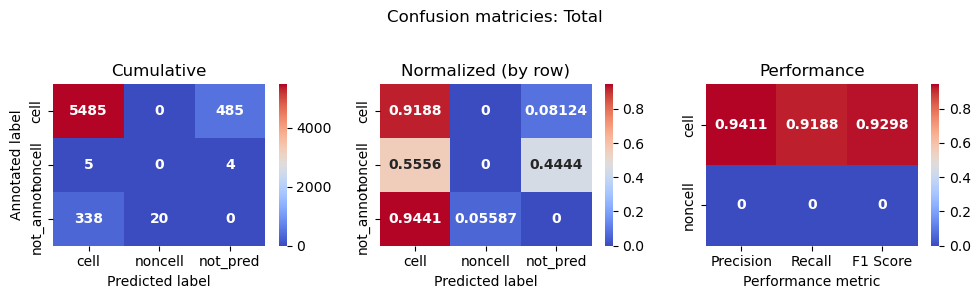

In [7]:
# Classification Matrix Plots
F1_scores = performance[2::3, :-1]
opt_vals = np.unravel_index(np.argmax(F1_scores, axis=None), F1_scores.shape)
metric_df = evaluate.annot_pred_overlap(blocks, opt_vals[0] + 1, 'flow', True)

evaluate.plot_cm(metric_df)

### Plot Example Images with Masks

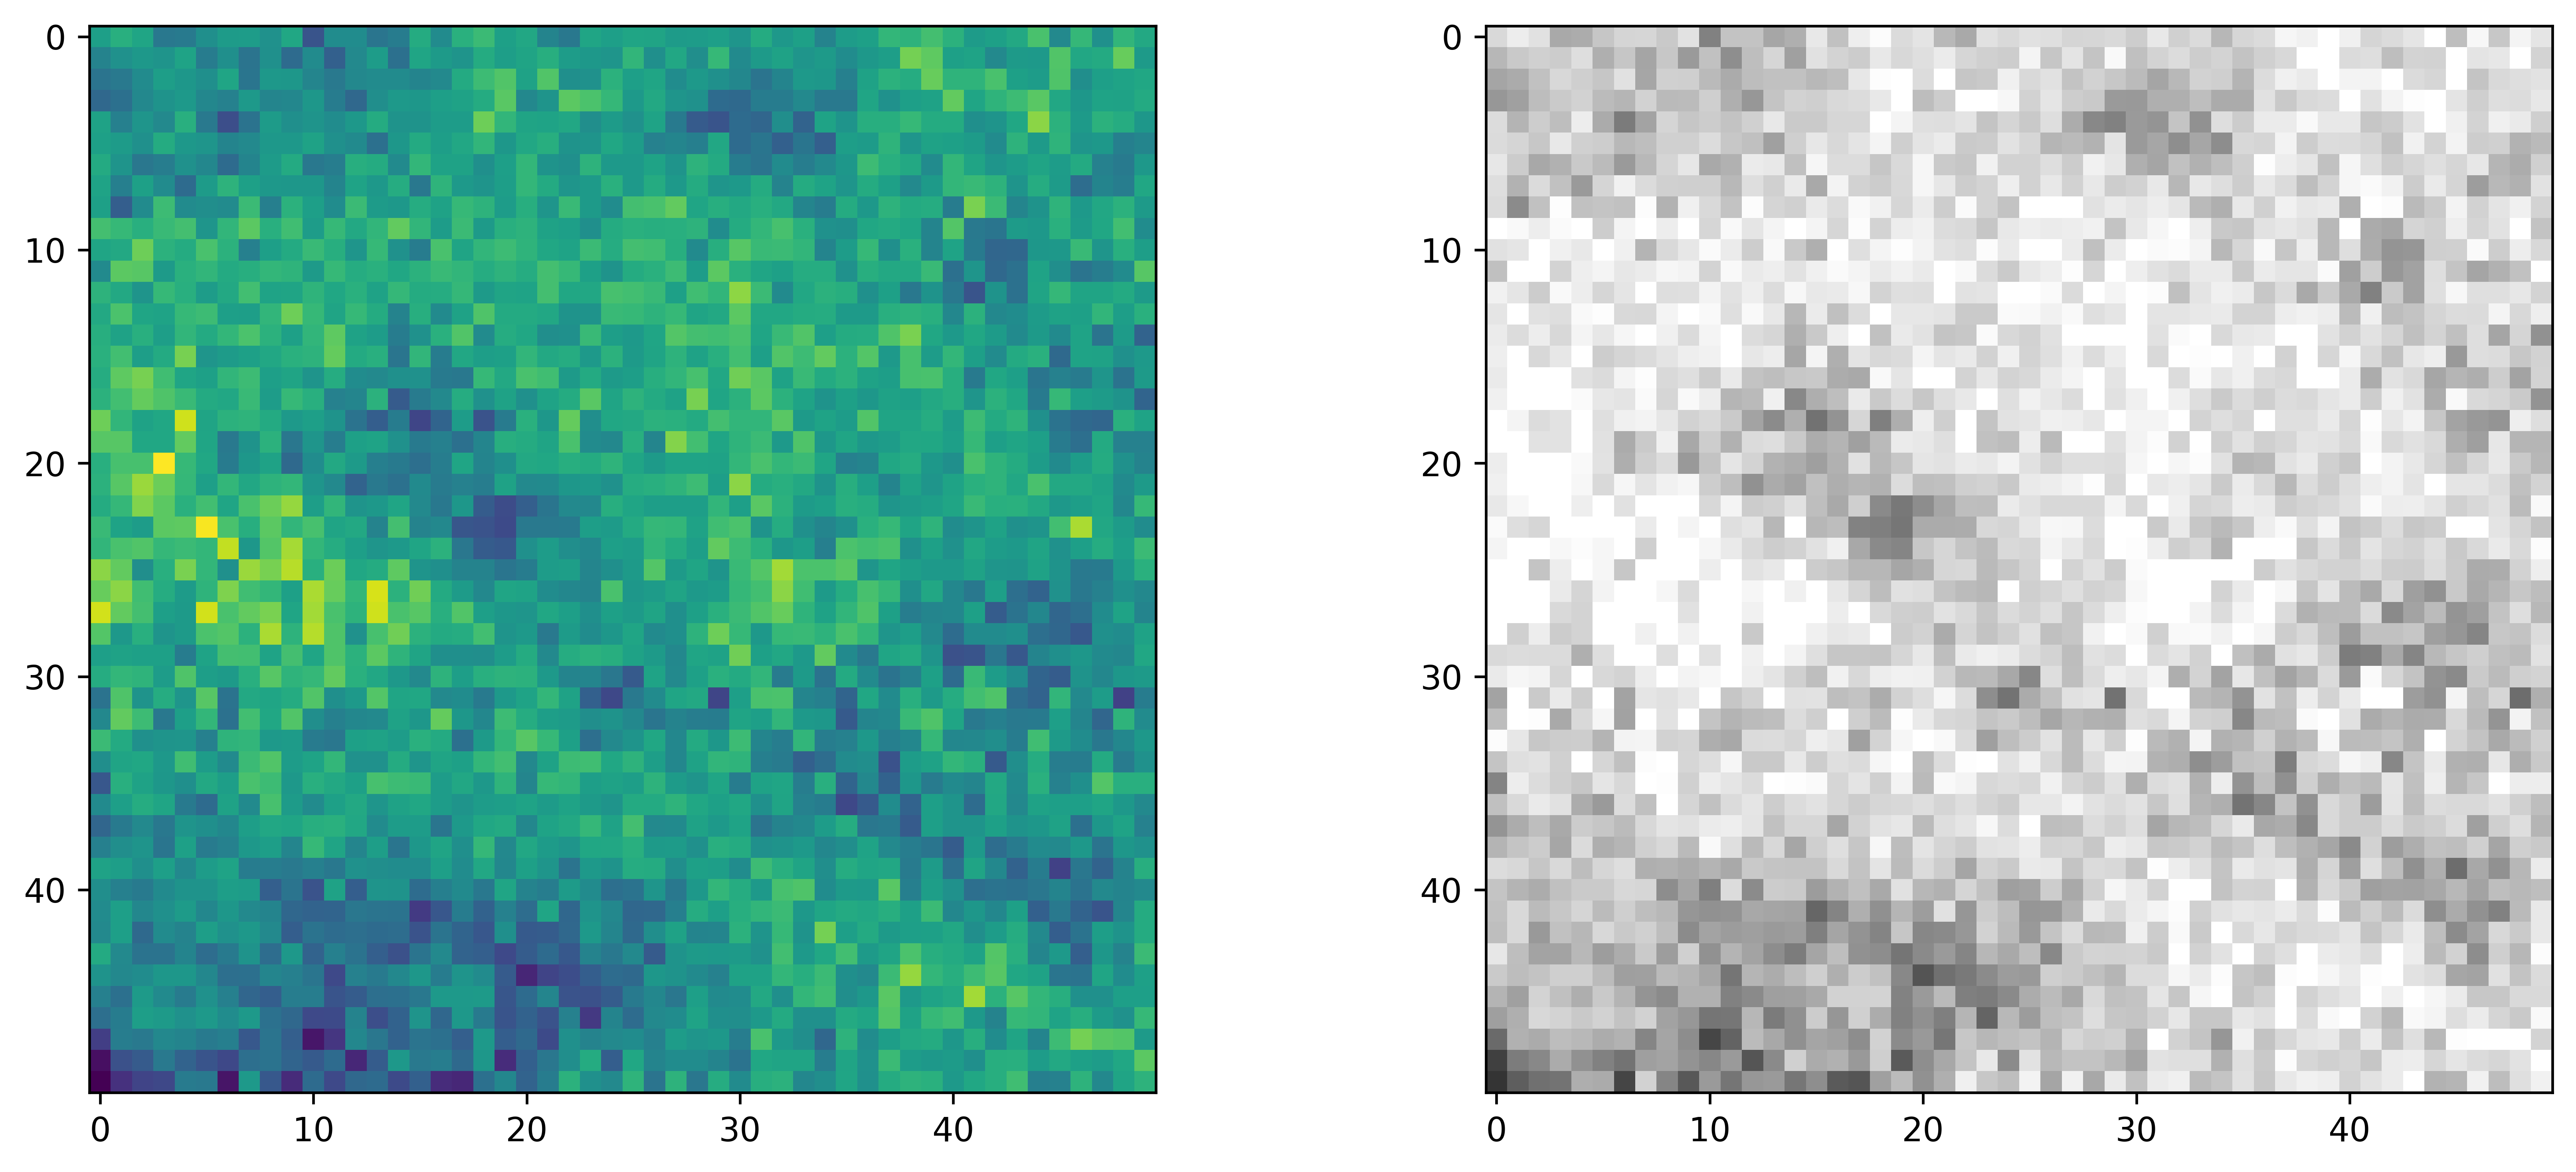

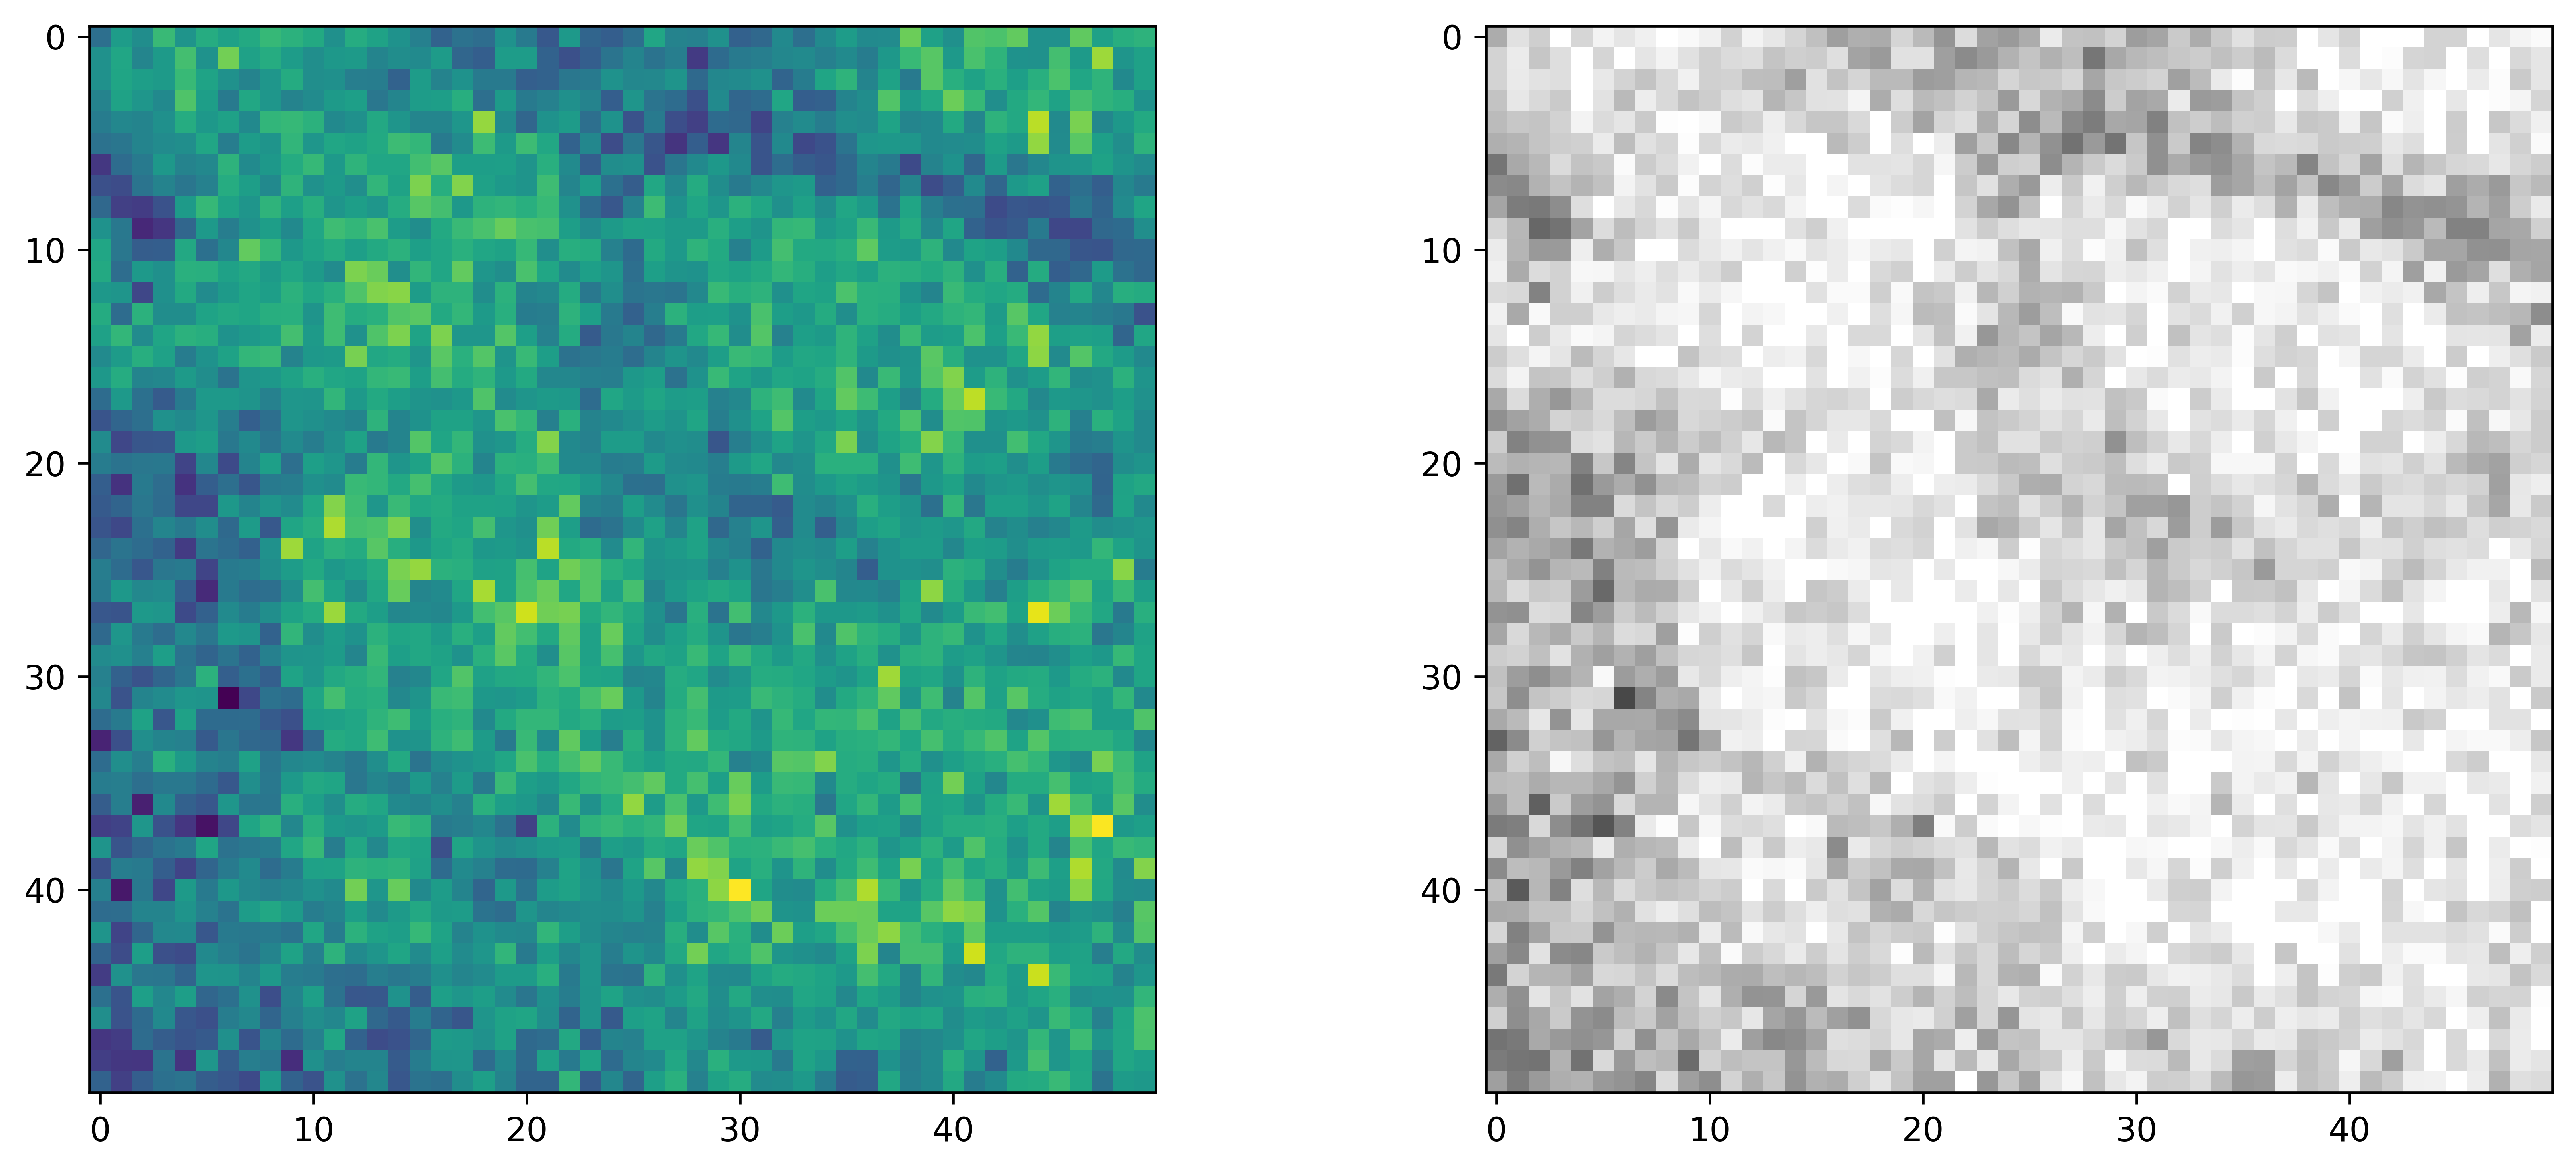

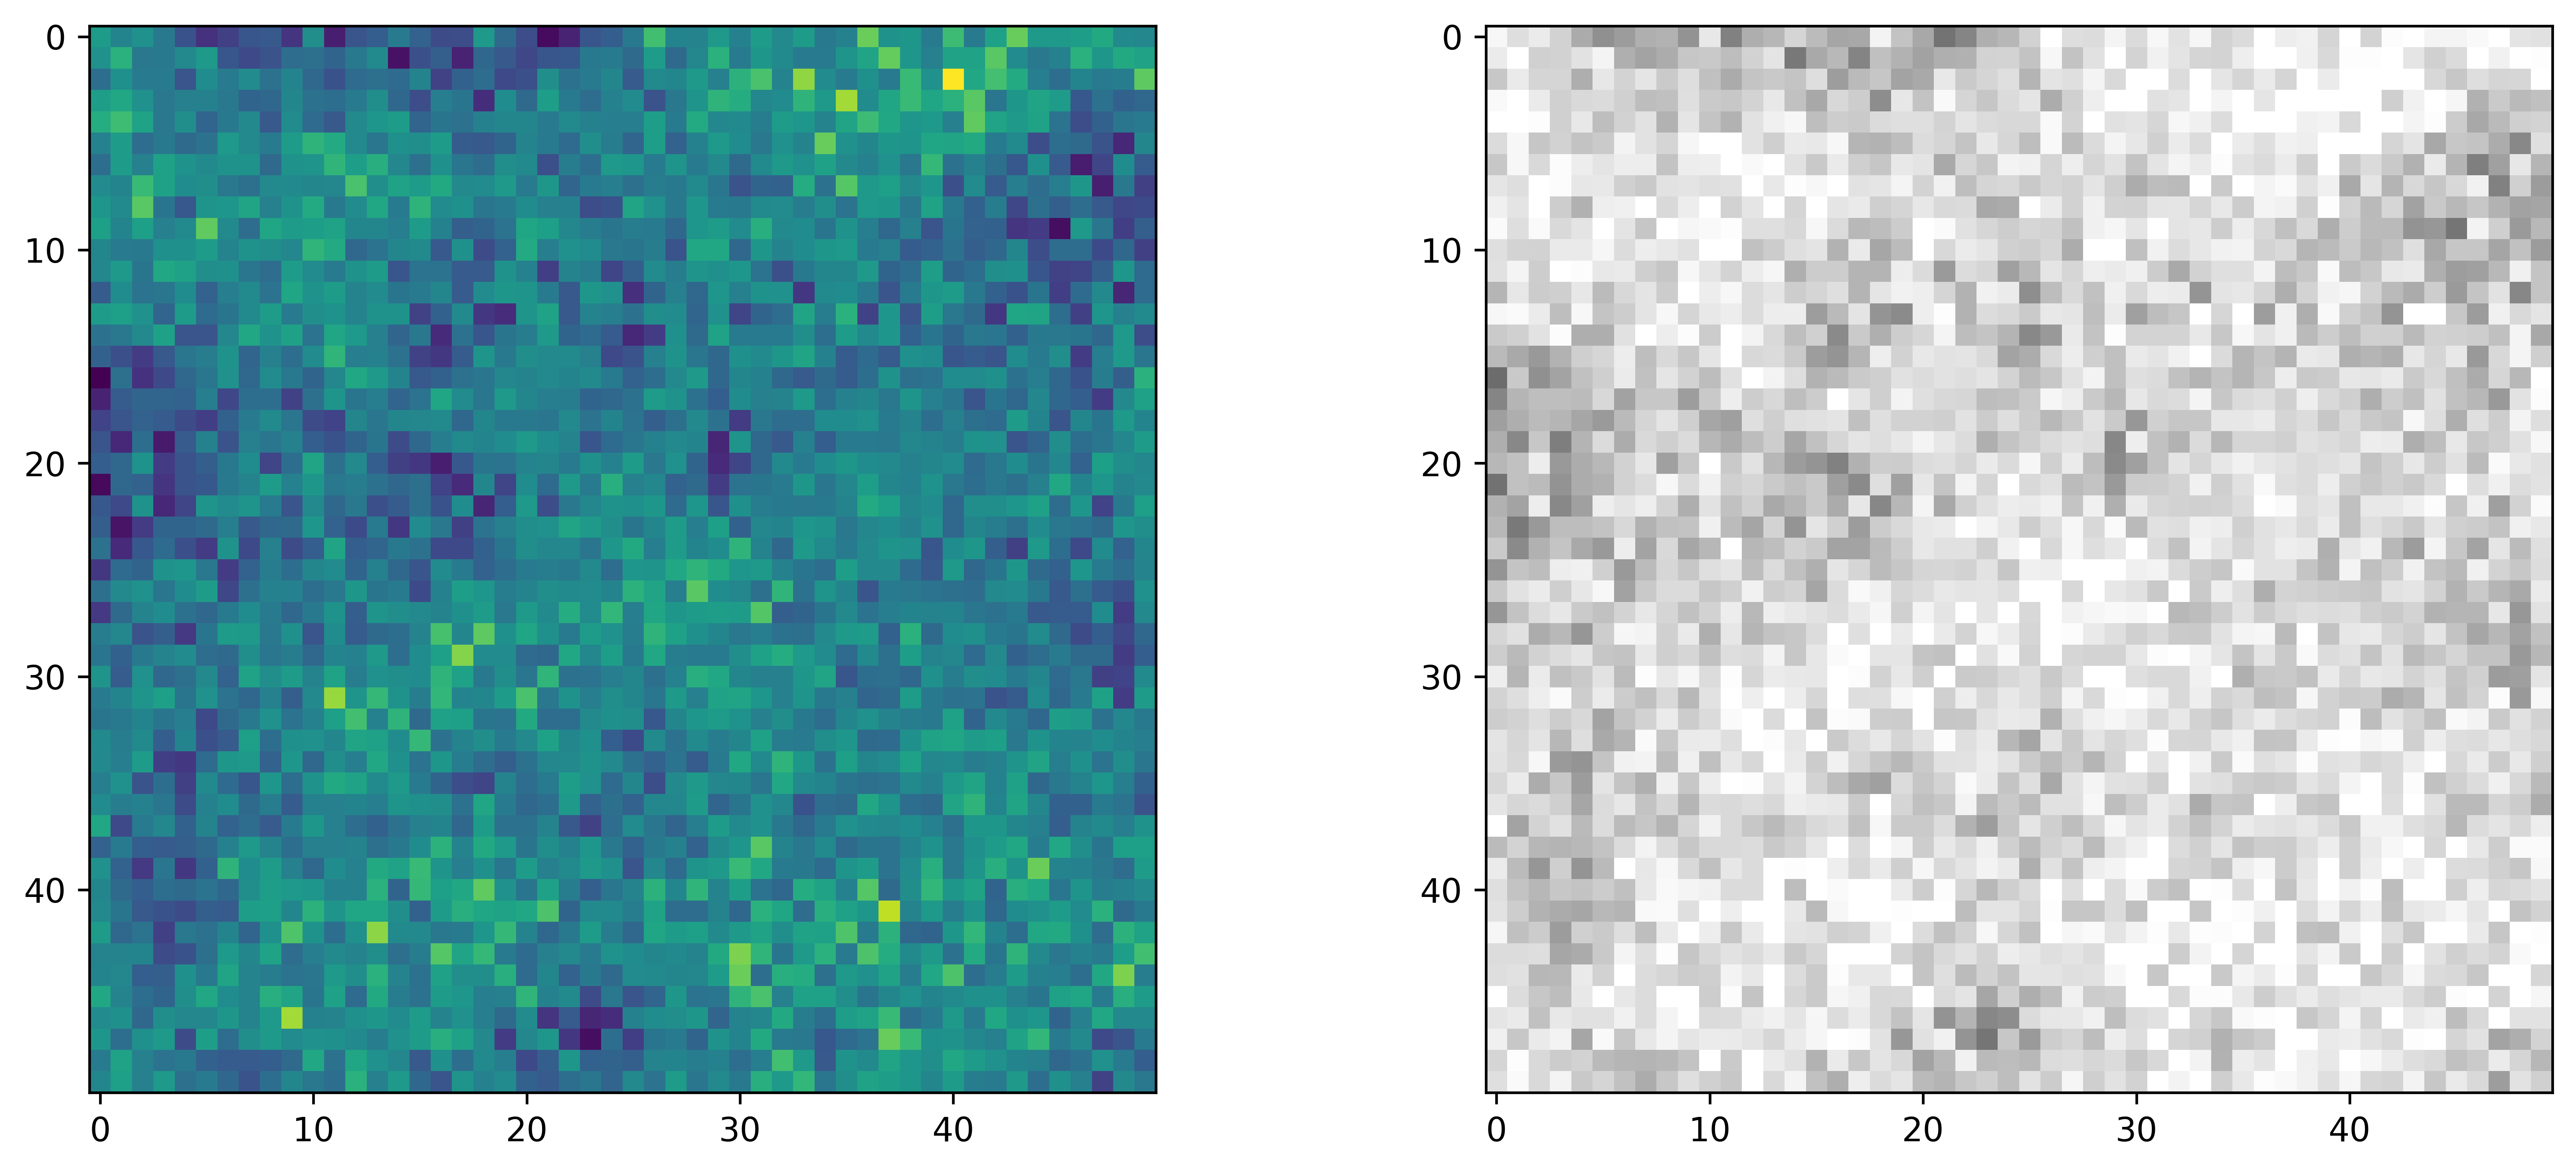

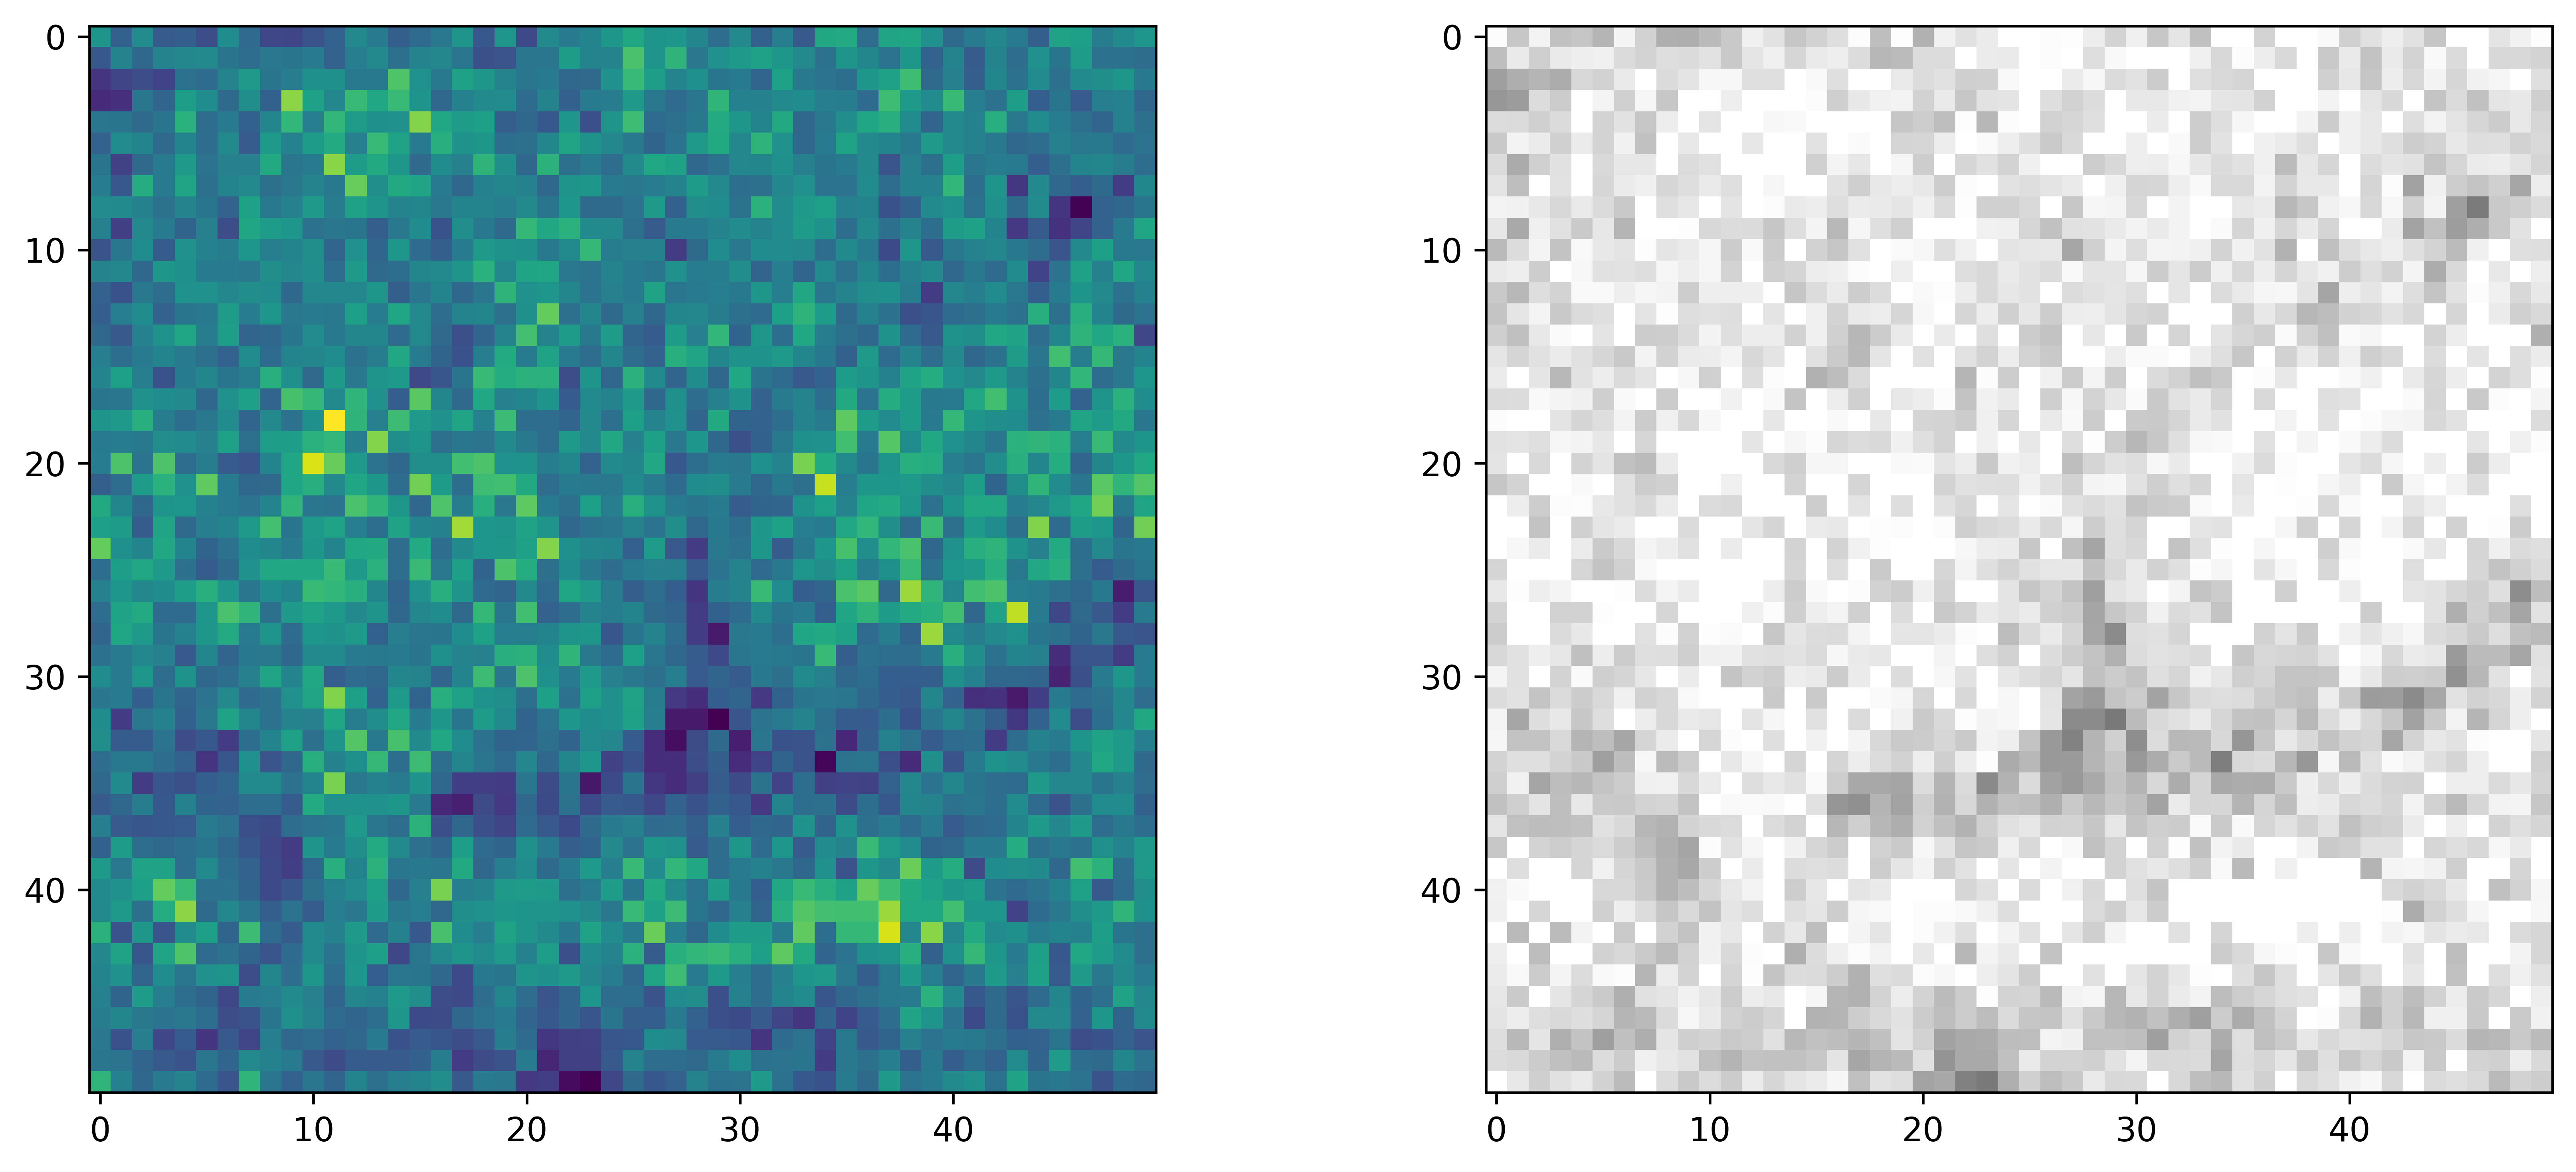

In [9]:
# plot output from 3D flows => masks
from cellpose import plot, utils
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 600

img_file = blocks['4']['signal']
mask_file = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_train/flow/block_4_signal_cp_masks.tif'


crop = [100, 150]

#plot cells with masks
for idx in range(60,91,10):
    maski = masks[idx, crop[0]:crop[1], crop[0]:crop[1]]
    imgi = img[idx, crop[0]:crop[1], crop[0]:crop[1]]
    overi = plot.mask_overlay(imgi, maski)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ax[0].imshow(imgi)
    ax[1].imshow(overi)
    
    plt.tight_layout()
    plt.show()

### Plot Error Along Axes

### Plot Flux of Missed Cells